# Parallax effect

This tutorial present how the volumetric absorption of photons can be taken into account to explain the peak shift at large incidence angle and quantify parallax the effet.

This effect apparently disturbes the calibration at very large scattering angle and is likely to jeopardize PDF measurements.

![experiment description](parallax.svg)

Let's consider the sensor of a detector and assume it is a thick slab of material. This sensor is characterized by its photon absorption, but since it is not that obvious to find the numerical values, we will consider the **thickness** and the **efficiency** of the sensor (measured normaly). The efficiency depends on the incident photon energy which is assumed monochromatic.

The volumic absorption follows a first order (exponential) decay, assymmetric, which is the cause of the apparent shift of peaks in the calibration procedure. This tutorial tries to quantify the effect.

For most of the tutorial, the Perkin-Elmer flat panel detector is considered, it has a dopped CsI sintillator of 200µm which has an apparent efficiency of 80% at 35keV. The pixel size is 100µm.

The incoming beam is considered with a Gaussian shape, but circular and square signals should be considered as well. We will assume the FWHM of the beam is 1mm and will tune this parameter. It correspond in first approximation to the sample size.

In [1]:
%matplotlib nbagg
import time
start_time = time.perf_counter()
import numpy
from matplotlib.pyplot import subplots
import numexpr
import scipy.integrate, scipy.signal
from math import sin, cos, pi, log, sqrt
EPS = numpy.finfo("float64").eps

In [33]:
class Decay:
    OVER = 64 # Default oversampling value
    def __init__(self, thickness, efficiency):
        """Class to simulate the parallax effect
        
        :param thickness: thickness of the sensible layer, in meter or mm, µm...
        :param efficiency: efficiency for the sensor material between 0 and 1
        """
        self.thickness = float(thickness)
        self.efficiency = float(efficiency)
        self.lam = - log(1.0-efficiency)/thickness
        self.formula = numexpr.NumExpr("where(x<0, 0.0, l*exp(-l*x))")
        
    def __call__(self, x):
        "Calculate the absorption at position x"
        return self.formula(self.lam, x)
    
    def integrate(self, x):
        """Integrate between 0 and x
        
        :param x: length of the path, same unit as thickness
        """
        return scipy.integrate.quad(s, 0.0, x)
    
    def test(self):
        """Validate the formula for  lambda
        sum(decay) between 0 and thickness is efficiency"""
        value, error = self.integrate(self.thickness)
        assert abs(value - self.efficiency) < error 
    
    def absorption(self, angle, over=None):
        """Calculate the absorption along the path for a beam inclined with the given angle
        :param angle: 
        :return position (along the detector), absorption (normalized)
        """
        over = over or self.OVER
        angle_r = numpy.deg2rad(angle)
        length = self.thickness/cos(angle_r)
        step = length/over
        pos = numpy.linspace(0, length, over)
        decay = self.__call__(pos)
        decay /= decay.sum()   # Normalize the decay
        pos *= sin(angle_r) # rotate the decay to have it in the detector plan:
        return pos, decay
    
    def gaussian(self, width, over=None):
        """Model the beam as a gaussian
        
        :param width: FWHM of the gaussian curve 
        :param over: oversampling factor, take that many points to describe the peak
        :return: position, intensity (normalized)
        """
        over = over or self.OVER
        if width<EPS:
            print("Warning, width too small")
            width = EPS
        step = width / over
        sigma = width/(2.0*sqrt(2.0*log(2.0)))
        nsteps = 2*int(3*sigma/step+1) + 1
        pos = (numpy.arange(nsteps) - nsteps//2) * step
        peak = numexpr.evaluate("exp(-pos**2/(2*(sigma**2)))")
        peak /= peak.sum()
        return pos, peak

    def square(self, width, over=None):
        """Model the beam as a square signal
        
        :param width: width of the signal
        :param over: oversampling factor, take that many points to describe the peak
        :return: position, intensity (normalized)
        """
        over = over or self.OVER
        if width<EPS:
            print("Warning, width too small")
            width = EPS
        step = width / over
        nsteps = 2*int(2*width/step+1) + 1
        pos = (numpy.arange(nsteps) - nsteps//2) * step
        peak = numexpr.evaluate("where(abs(pos)<=width/2, 1.0, 0.0)")
        peak /= peak.sum()
        return pos, peak
    
    def circle(self, width, over=None):
        """Model the beam as a circular signal
        
        :param width: Diameter of the beam
        :param over: oversampling factor, take that many points to describe the peak
        :return: position, intensity (normalized)
        """
        over = over or self.OVER
        if width<EPS:
            print("Warning, width too small")
            width = EPS
        step = width / over
        nsteps = 2*int(width/step+2) + 1
        pos = (numpy.arange(nsteps) - nsteps//2) * step
        peak = numexpr.evaluate("where(abs(pos)<=width/2, sqrt(1.0-(2.0*pos/width)**2), 0.0)")
        peak /= peak.sum()
        return pos, peak
    
    def convolve(self, width, angle, beam="gaussian", over=None):
        """Calculate the line profile convoluted with parallax effect
        
        :param width: FWHM of the peak, same unit as thickness
        :param angle: incidence angle in degrees
        :param over: oversampling factor for numerical integration
        :return: position, intensity(position)
        """
        over = over or self.OVER
        angle_r = numpy.deg2rad(angle)
        pos_dec, decay = self.absorption(angle, over)
        peakf = self.__getattribute__(beam)
        pos_peak, peak = peakf(width/cos(angle_r), over=over)
        #Interpolate grids ...
        pos_min = min(pos_dec[0], pos_peak[0])
        pos_max = max(pos_dec[-1], pos_peak[-1])
        step = min((pos_dec[-1] - pos_dec[0])/(pos_dec.shape[0]-1),  
                   (pos_peak[-1] - pos_peak[0])/(pos_dec.shape[0]-1))
        if step<EPS:
            step = max((pos_dec[-1] - pos_dec[0])/(pos_dec.shape[0]-1),  
                       (pos_peak[-1] - pos_peak[0])/(pos_dec.shape[0]-1))
        nsteps_2 = int(max(-pos_min, pos_max)/step + 0.5)
        pos = (numpy.arange(2*nsteps_2+1) - nsteps_2) *  step
        big_decay = numpy.interp(pos, pos_dec, decay, left=0.0, right=0.0)
        dsum = big_decay.sum()
        if dsum == 0:
            big_decay[numpy.argmin(abs(pos))] = 1.0
        else:
            big_decay /= dsum
        big_peak = numpy.interp(pos, pos_peak, peak, left=0.0, right=0.0)
        return pos, scipy.signal.convolve(big_peak, big_decay, "same")
    
    def plot_displacement(self, width, angle, beam="gaussian", ax=None):
        """Plot the displacement of the peak depending on the FWHM and the incidence angle"""
        if ax is None:
            fig,ax = subplots()
        ax.set_xlabel("Radial displacement on the detector (mm)")
        c = self.absorption(angle)
        ax.plot(*c, label="Absorption")
        peakf = self.__getattribute__(beam)
        c = peakf(width)
        ax.plot(*c, label=f"peak w={width} mm")
        c = peakf(width/cos(angle*pi/180))
        ax.plot(*c, label=f"peak w={width} mm, inclined")

        c = self.convolve(width, angle, beam=beam)
        ax.plot(*c, label="Convolution")
        idx = numpy.argmax(c[1])
        maxi = self.measure_displacement(width, angle, beam=beam)
        ax.annotate(f"$\delta r$={maxi:.3f}", (maxi, c[1][idx]),
                   xycoords='data',
                   xytext=(0.8, 0.5), textcoords='axes fraction',
                   arrowprops=dict(facecolor='black', shrink=0.05),
                   horizontalalignment='right', verticalalignment='top',)
        ax.set_title(f"Profile {beam}, width: {width}mm, angle: {angle}°")
        ax.legend()
        return ax
    
    def measure_displacement(self, width, angle, beam="gaussian", over=None):
        """Measures the displacement of the peak due to parallax effect"""
        over = over or self.OVER
        x,y = self.convolve(width, angle, beam=beam, over=over)
        ymax = y.max()
        idx_max = numpy.where(y==ymax)[0]
        if len(idx_max)>1:
            return x[idx_max].mean()
        
        idx = idx_max[0]
        if idx>1 or idx<len(y)-1:
            #Second order tailor expension
            f_prime = 0.5*(y[idx+1]-y[idx-1])
            f_sec = (y[idx+1]+y[idx-1]-2*y[idx])
            if f_sec == 0:
                print('f" is null')
                return x[idx]
            delta = -f_prime/f_sec
            if abs(delta)>1: 
                print("Too large displacement")
                return x[idx]
            step = (x[-1]-x[0])/(len(x)-1)
            return x[idx] + delta*step
        return x[idx]
            
        
# s = Decay(0.2, 0.8) #200µm, 80% efficiency
s = Decay(0.45, 0.35) #450µm, 35% efficiency 450µ Si @ 20keV
s.test()

<IPython.core.display.Javascript object>


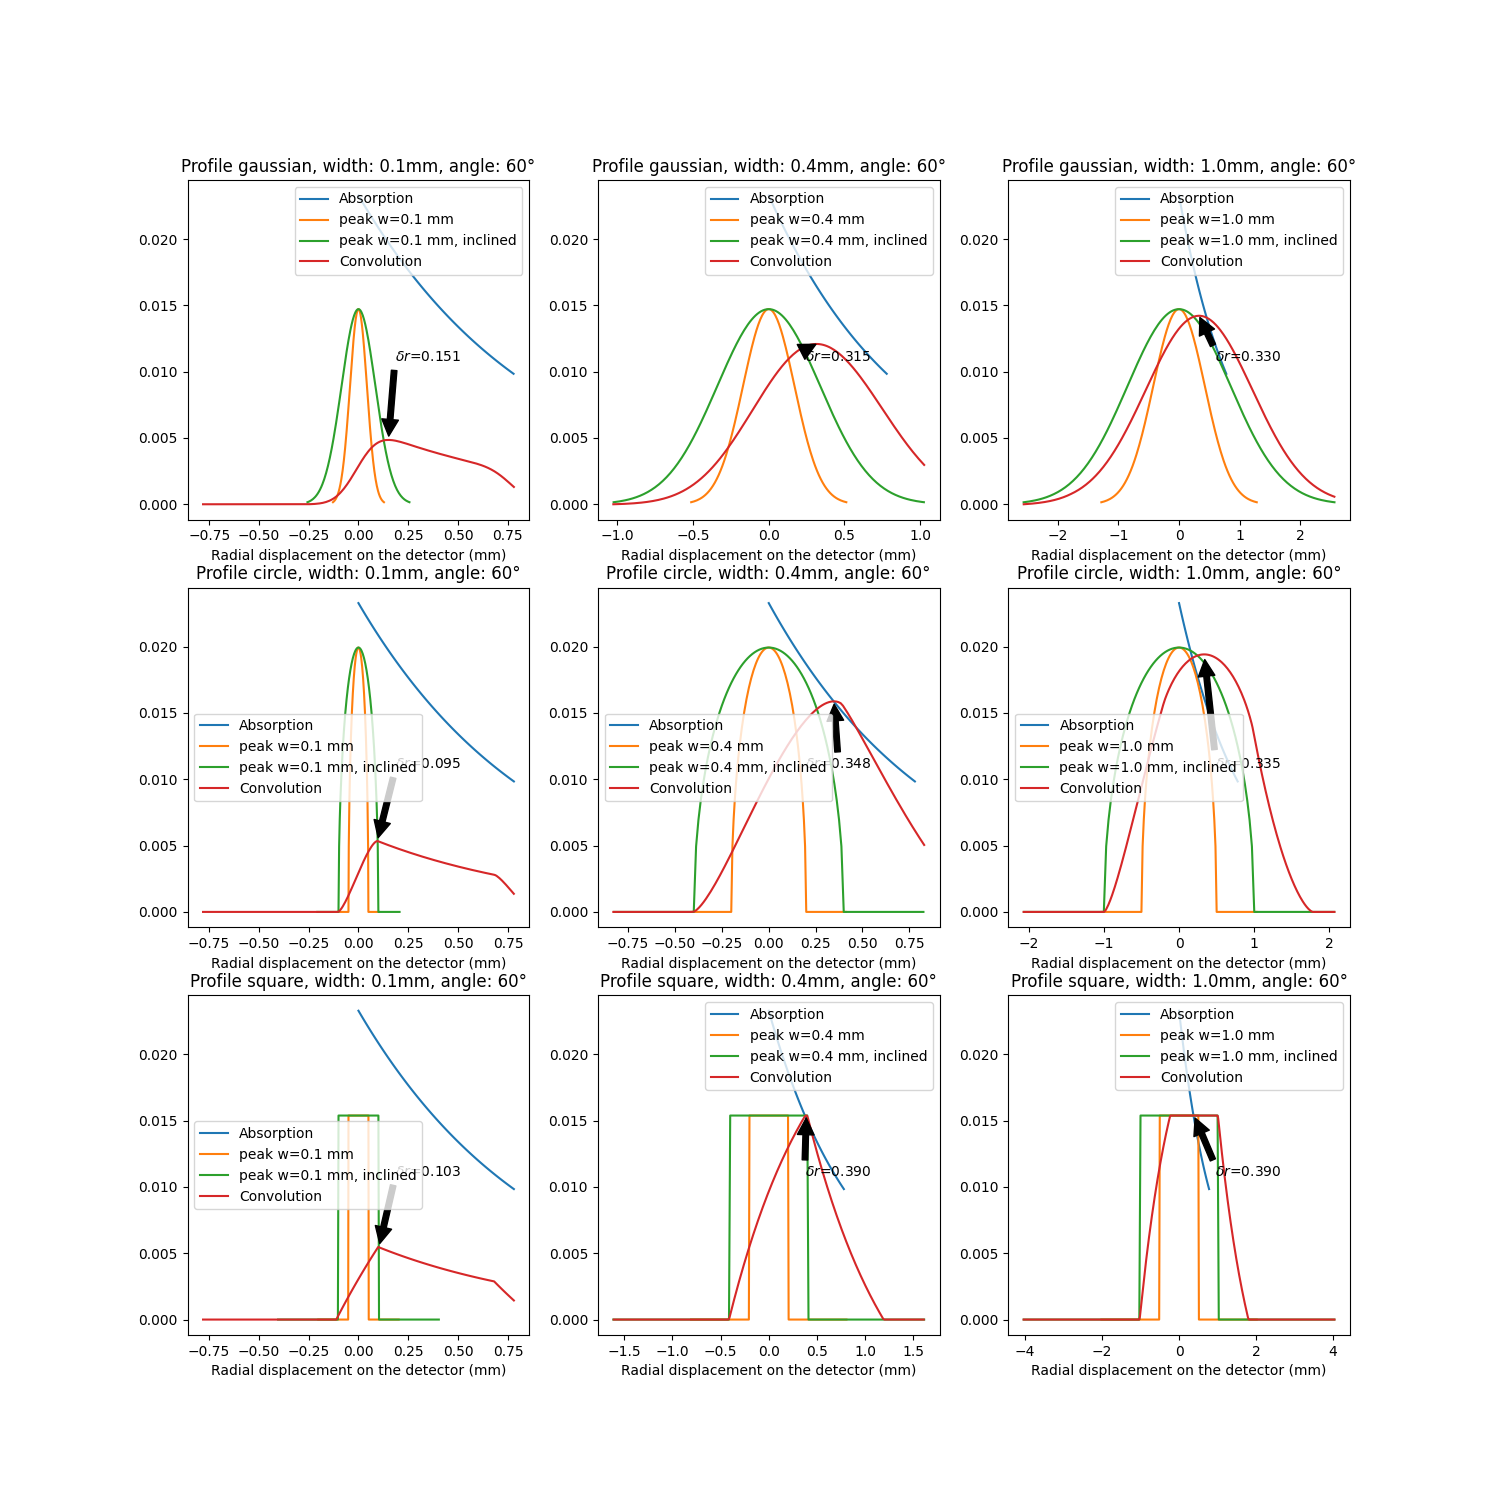

In [34]:
fig, ax = subplots(3, 3, figsize=(15,15))
for id0, shape in enumerate(("gaussian", "circle", "square")):
    for id1, w in enumerate((0.1, 0.4, 1.0)):
        p=s.plot_displacement(w, 60, beam=shape, ax=ax[id0, id1])

<IPython.core.display.Javascript object>


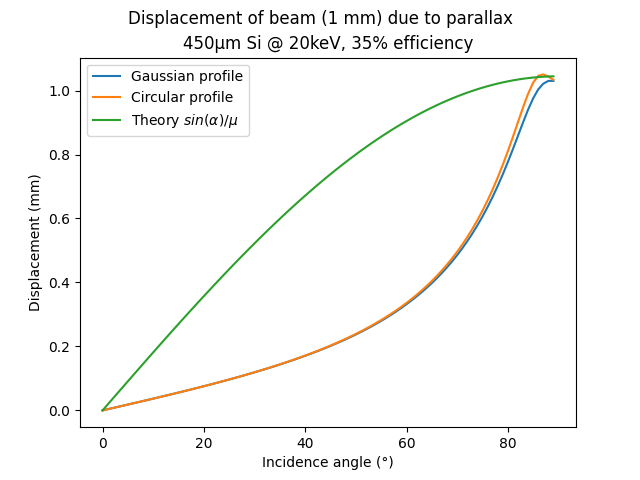

In [35]:
width = 1
angles = numpy.arange(90)
displ_g = [s.measure_displacement(width, a, beam="gaussian", over=1024) for a in angles]
displ_c = [s.measure_displacement(width, a, beam="circle", over=1024) for a in angles]
displ_s = [s.measure_displacement(width, a, beam="square", over=1024) for a in angles]

fig,ax = subplots()

ax.plot(angles, displ_g, label="Gaussian profile")
ax.plot(angles, displ_c, label="Circular profile")
# ax.plot(angles, displ_s, label="Square profile")
ax.set_title("450µm Si @ 20keV, 35% efficiency")
# ax.set_title("200µm CsI @ 35keV, 80% efficiency")
fig.suptitle(f"Displacement of beam ({width} mm) due to parallax")
ax.set_ylabel("Displacement (mm)")
ax.set_xlabel("Incidence angle (°)")
ax.plot(angles, numpy.sin(numpy.deg2rad(angles))/s.lam, label=r"Theory $sin(\alpha)/\mu$")
ax.legend()
# fig.savefig("Perkin.png")
fig.savefig("Pilatus.png")
pass

## Conclusion

The parallax effect induces a displacement of the ring, the numerical value is almost proportional to the scattering angle for all useable incidence angles (<60°) and represents at maximum one pixel (100µm).

This tutorial can directly be re-run for photon counting detectors like the Pilatus detector manufactured by Dectris, with the efficiency curves provided by the manufacturer: 
![Efficiency of Si-based detector](silicon_sensors_QE_450_1000.webp)
![Efficiency of CdTe-based detector](CdTe_sensors-QE_CdTe_.jpg__750x562_q90_subsampling-2.jpg)

In [5]:
print(f"Execution time: {time.perf_counter()-start_time:.3f}s")

Execution time: 39.376s


In [7]:
1/s.lam

0.12426698691192237